In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as random
key = random.key(0)
import argparse
import sys
import os
sys.path.append("..")
from traditional_solvers import Dx, Dxx, implicit_midpoint, gauss_legendre_4, gauss_legendre_6

###############INITIAL CONDITION####################

def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, η=6., P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=1.5, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    u0 = (-6./-η)*2 * c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += (-6./-η)*2 * c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return u0

#################PARAMETERS####################

η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 252 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 378 # N+1 time points 

t0 = 0.0 # initial time
t_final = 3.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ, "dx" : dx}
SPATIAL_ORDER = 4

#############EQUATION####################
def f(t, u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    return -Dx(η/2*u**2 + γ**2 * Dxx(u, dx), dx)

#############HAMILTONIANS################
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = -η/6*u**3 + 0.5*γ**2*Dx(u, dx)**2
    return dx*jnp.sum(integrand)

def H_mass(u, args):
    return dx * jnp.sum(u)

def H_momentum(u, args):
    return dx * jnp.sum(u**2)

In [145]:
def f(u, dx):
    H = lambda u : jnp.sum(1/(2*dx**2)*(jnp.roll(u, -1)-u)**2-u**3)
    return Dx(jax.grad(H)(u), dx)

In [146]:
import optimistix as optx

In [ ]:
def avf(f, u0, dt, t, args, rtol, atol):
    s = jnp.linspace(0, 1, len(u0))[:,None]
    def step(un, t):
        def eq(u_next, args):
            I = jnp.sum(f((1-s)*un + s*u_next, dx), axis=0)*dx
            return u_next - (un + dt*I)

        solver = optx.Newton(rtol,atol)
        u_next = optx.root_find(eq, solver, un, args, max_steps=10, throw = False).value
        
        return u_next, un
    
    _, u_arr = jax.lax.scan(step, u0, t)
    
    return u_arr


In [177]:
u0 = initial_condition_kdv(x, key, η, P)

In [180]:
u = avf(f, u0, dt, t, None, 1e-10, 1e-10)

In [181]:
print(u.shape)

(379, 252)


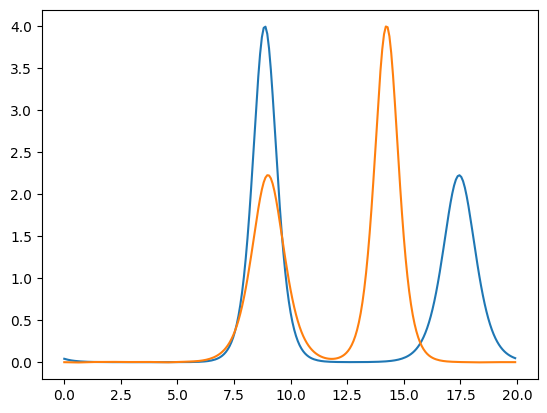

In [182]:
plt.figure()
plt.plot(x, u0, label="Initial condition")
plt.plot(x, u[-1], label="Final condition")
plt.show()

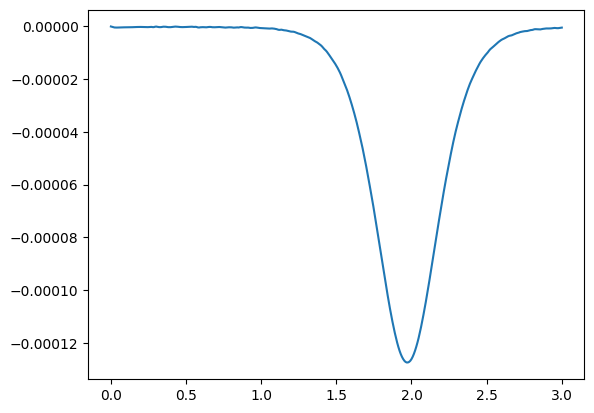

In [161]:
H = lambda u : jnp.sum(1/(2*dx**2)*(jnp.roll(u, -1)-u)**2-u**3)/dx

Hs = jax.vmap(H)(u)

plt.figure()
plt.plot(t, Hs-Hs[0])
plt.show()